# Code for Fig. 5 and fig. S5 of
#### Yeager et al., 2021: An Outsized Role for the Labrador Sea in the Multidecadal Variability of the Atlantic Overturning Circulation, *Science Advances*.

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [3]:
datadir = '/glade/scratch/yeager/YeagerEA_ScienceAdvances_2021/'
f2_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.MOCsig.nc'
f3_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.WMF.nc'

ds2_hr = open_POPdataset(f2_hr) 
ds3_hr = open_POPdataset(f3_hr) 

In [4]:
# Add additional regions to WMF datasets
ds3_hr1 = ds3_hr.isel(wmf_region=[1,2,3,5,6]).sum('wmf_region')
ds3_hr1 = ds3_hr1.assign_coords({'wmf_region':'ALL minus LAB (7)'})
ds3_hr2 = ds3_hr.isel(wmf_region=[1,2,3]).sum('wmf_region')
ds3_hr2 = ds3_hr2.assign_coords({'wmf_region':'IRM+SPG (8)'})
ds3_hr3 = ds3_hr.isel(wmf_region=[1,4]).sum('wmf_region')
ds3_hr3 = ds3_hr3.assign_coords({'wmf_region':'LAB+SPG-west (9)'})
ds3_hr4 = ds3_hr.isel(wmf_region=[2,3]).sum('wmf_region')
ds3_hr4 = ds3_hr4.assign_coords({'wmf_region':'IRM+SPG-east (10)'})
ds3_hr = xr.concat([ds3_hr,ds3_hr1,ds3_hr2,ds3_hr3,ds3_hr4],dim='wmf_region')

## Compute Anomalies and Std Dev (years 200-500)

In [5]:
ds2_hr_ann = ds2_hr.groupby('time.year').mean('time')
ds3_hr_ann = ds3_hr.groupby('time.year').mean('time')

ds2_hr_ann=ds2_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds3_hr_ann=ds3_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))

In [6]:
# Annual Anomalies
ds2_hr_mean = ds2_hr_ann.mean('time')
ds2_hr_annanom = ds2_hr_ann - ds2_hr_mean
ds3_hr_mean = ds3_hr_ann.mean('time')
ds3_hr_annanom = ds3_hr_ann - ds3_hr_mean

In [7]:
# Annual Detrended Anomalies
ds2_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_hr_annanom.notnull())
ds3_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds3_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds3_hr_annanom.notnull())

## Temporal Filtering

In [8]:
# 10-year butterworth low-pass filter
fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
nyquist = fs / 2          # 0.5 times the sampling frequency
cutoff = fs/10            # 10-year cutoff frequency
cutoff = cutoff/nyquist   # as fraction of nyquist  
print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
filtb, filta = signal.butter(4, cutoff, 'lowpass')


cutoff=  10.0  years


#### Now Apply Filter Using Xarray apply_ufunc

In [9]:
# Low-Pass (lp) anomalies:
ds2_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_hr_annanom_dt.notnull())
ds3_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds3_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds3_hr_annanom_dt.notnull())

In [10]:
# Detrended, filtered Std Dev:
ds2_hr_anndtstd = ds2_hr_annanom_dt.std('time')
ds2_hr_lpdtstd = ds2_hr_lpanom_dt.std('time')

ds3_hr_anndtstd = ds3_hr_annanom_dt.std('time')
ds3_hr_lpdtstd = ds3_hr_lpanom_dt.std('time')

In [11]:
# First, create low-pass-filtered, detrended AMOC that includes the mean
ds2_hr_lpann_dt = ds2_hr_lpanom_dt + ds2_hr_mean
ds3_hr_lpann_dt = ds3_hr_lpanom_dt + ds3_hr_mean

### LSW density range determined here:

In [12]:
ds3_hr_lpann_dt.isel(wmf_region=4).mean('time').WMF.sel(sigma_wmf=slice(36.9,37.2)).values,ds3_hr_lpann_dt.sel(sigma_wmf=slice(36.9,37.2)).sigma_wmf.values

(array([-0.15392032,  0.37033764,  1.42853378,  1.93606328,  0.55137143,
         0.01353341]),
 array([36.925, 36.975, 37.025, 37.075, 37.125, 37.175]))

In [13]:
hr_lsw = [36.95, 37.175]
hr_dlsw = [37.0625, 37.175]

In [14]:
ds3_hr_lpann_dt.wmf_region

<xarray.DataArray 'wmf_region' (wmf_region: 11)>
array(['All (>0)', 'SPG_west (1)', 'SPG_east (2)', 'Irminger Sea (3)',
       'Labrador Sea (4)', 'Norwegian Sea (5)', 'Arctic (6)',
       'ALL minus LAB (7)', 'IRM+SPG (8)', 'LAB+SPG-west (9)',
       'IRM+SPG-east (10)'], dtype=object)
Coordinates:
  * wmf_region  (wmf_region) object 'All (>0)' ... 'IRM+SPG-east (10)'

### deep LSW (dLSW) is defined here:

In [15]:
hr_dlsw = [(hr_lsw[1]-hr_lsw[0])*0.5 +hr_lsw[0], hr_lsw[1]]

In [16]:
hr_dlsw

[37.0625, 37.175]

# fig. S5

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/ipykernel_launcher.py:238: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


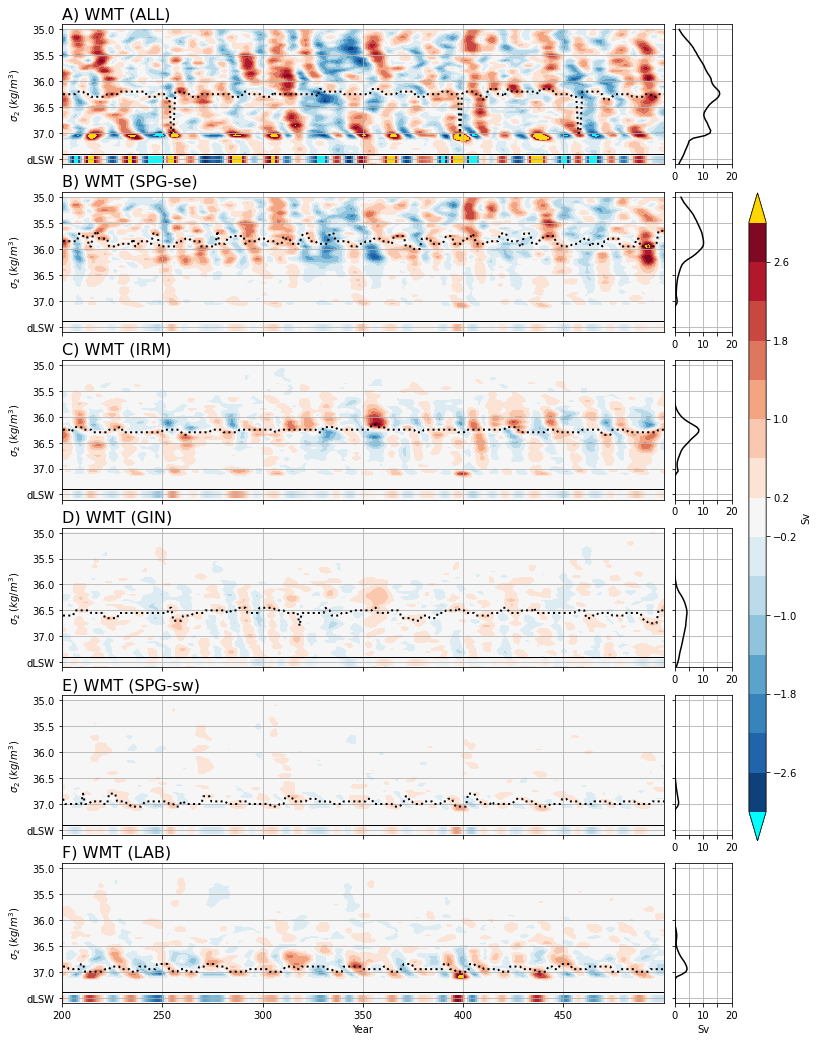

In [20]:
# Year 200-500 hovmuller plots
fig = plt.figure(figsize=(12, 18))
spec = fig.add_gridspec(ncols=10, nrows=6, figure=fig)
ax1 = fig.add_subplot(spec[4, 0:9])
ax1a = fig.add_subplot(spec[4, 9])
ax2 = fig.add_subplot(spec[0, 0:9])
ax2a = fig.add_subplot(spec[0, 9])
ax3 = fig.add_subplot(spec[1, 0:9])
ax3a = fig.add_subplot(spec[1, 9])
ax4 = fig.add_subplot(spec[2, 0:9])
ax4a = fig.add_subplot(spec[2, 9])
ax5 = fig.add_subplot(spec[3, 0:9])
ax5a = fig.add_subplot(spec[3, 9])
ax6 = fig.add_subplot(spec[5, 0:9])
ax6a = fig.add_subplot(spec[5, 9])

ylat = 45.
xlim=[200,500]
ylim=[37.6,34.9]
ylim2=[28.1, 27.0]

#tann = np.linspace(6.5, 495.5, num=490)
tann = np.linspace(200.5, 500.5, num=301)
#levs = np.arange(0,21,1)*0.25-2.5
levs = np.arange(0,16,1)*0.4 - 3
levs2 = [-3,-2,-1,1,2,3]
sigslice = slice(36.95,38.0)
sigclrs = ['w','w','w','k','k','k']
#sigclrs = ['cyan','cyan','cyan','gold','gold','gold']
yticks = [37.5,37,36.5,36,35.5,35]
yticklabs = ('dLSW','37.0','36.5','36.0','35.5','35.0')
xticks1 = [200,250,300,350,400,450]
xtick1labs = ('200','250','300','350','400','450')
xticks2 = [0,5,10,15,20]
xtick2labs = ('0','','10','','20')

#colmap = copy.copy(plt.cm.bwr)
#colmap = copy.copy(plt.cm.seismic)
colmap = copy.copy(plt.cm.RdBu_r)
overclr = 'gold'
#overclr = 'white'
underclr = 'cyan'

simstr = 'HR'
work2 = ds2_hr_lpanom_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=ylat,method='nearest')
work2a = ds2_hr_lpann_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=ylat,method='nearest')
work3 = ds3_hr_lpanom_dt.WMT
work3a = ds3_hr_lpann_dt.WMT
work4 = ds3_hr_lpanom_dt.WMF
work5 = work4.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')

markery = work5.copy()
markery.values[:] = 37.5
#work5 = work4.isel(wmf_region=0).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1]))
#work5 = work5.where(work5>0)
#lswmax = work5.sigma_wmf[work5.argmax(axis=1)]


ax2.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_title('A) WMT (ALL)', fontdict={'size':16}, loc='left')
cntr2 = ax2.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=0).T,cmap=colmap,levels=levs,extend='both')
cntr2.cmap.set_under(underclr)
cntr2.cmap.set_over(overclr)
cntr2.changed()
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=0).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr2b = ax2.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
clim = work3a.isel(wmf_region=0)
sig2max2 = clim.sigma_wmt[clim.argmax(axis=1)]
ax2.plot(tann, sig2max2,color='k',linewidth=2,linestyle='dotted')
ax2.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax2.grid()
ax2.set_xticks(xticks1)
ax2.set_xticklabels([])
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=0).mean('time')
ax2a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax2a.set_ylim(ylim)
ax2a.set_yticklabels([])
ax2a.set_xlim([0,20])
ax2a.set_xticks(xticks2)
ax2a.set_xticklabels(xtick2labs)
ax2a.grid()

ax3.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax3.set_ylim(ylim)
ax3.set_xlim(xlim)
ax3.set_title('B) WMT (SPG-se)', fontdict={'size':16}, loc='left')
cntr3 = ax3.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=2).T,cmap=colmap,levels=levs,extend='both')
cntr3.cmap.set_under(underclr)
cntr3.cmap.set_over(overclr)
cntr3.changed()
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=2).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr3b = ax3.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
clim = work3a.isel(wmf_region=2)
sig2max3 = clim.sigma_wmt[clim.argmax(axis=1)]
ax3.plot(tann, sig2max3,color='k',linewidth=2,linestyle='dotted')
ax3.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax3.grid()
ax3.set_xticks(xticks1)
ax3.set_xticklabels([])
ax3.set_yticks(yticks)
ax3.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=2).mean('time')
ax3a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax3a.set_ylim(ylim)
ax3a.set_yticklabels([])
ax3a.set_xlim([0,20])
ax3a.set_xticks(xticks2)
ax3a.set_xticklabels(xtick2labs)
ax3a.grid()

ax4.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax4.set_ylim(ylim)
ax4.set_xlim(xlim)
ax4.set_title('C) WMT (IRM)', fontdict={'size':16}, loc='left')
cntr4 = ax4.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=3).T,cmap=colmap,levels=levs, extend='both')
cntr4.cmap.set_under(underclr)
cntr4.cmap.set_over(overclr)
cntr4.changed()
clim = work3a.isel(wmf_region=3)
sig2max4 = clim.sigma_wmt[clim.argmax(axis=1)]
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr4b = ax4.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
ax4.plot(tann, sig2max4,color='k',linewidth=2,linestyle='dotted')
ax4.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax4.grid()
ax4.set_xticks(xticks1)
ax4.set_xticklabels([])
ax4.set_yticks(yticks)
ax4.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=3).mean('time')
ax4a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax4a.set_ylim(ylim)
ax4a.set_yticklabels([])
ax4a.set_xlim([0,20])
ax4a.set_xticks(xticks2)
ax4a.set_xticklabels(xtick2labs)
ax4a.grid()

ax5.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax5.set_ylim(ylim)
ax5.set_xlim(xlim)
ax5.set_title('D) WMT (GIN)', fontdict={'size':16}, loc='left')
cntr5 = ax5.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=5).T,cmap=colmap,levels=levs, extend='both')
cntr5.cmap.set_under(underclr)
cntr5.cmap.set_over(overclr)
cntr5.changed()
clim = work3a.isel(wmf_region=5)
sig2max5 = clim.sigma_wmt[clim.argmax(axis=1)]
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=5).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr5b = ax5.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
ax5.plot(tann, sig2max5,color='k',linewidth=2,linestyle='dotted')
ax5.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax5.grid()
ax5.set_xticks(xticks1)
ax5.set_xticklabels([])
ax5.set_yticks(yticks)
ax5.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=5).mean('time')
ax5a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax5a.set_ylim(ylim)
ax5a.set_yticklabels([])
ax5a.set_xlim([0,20])
ax5a.set_xticks(xticks2)
ax5a.set_xticklabels(xtick2labs)
ax5a.grid()

ax1.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title('E) WMT (SPG-sw)', fontdict={'size':16}, loc='left')
cntr1 = ax1.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=1).T,cmap=colmap,levels=levs,extend='both')
cntr1.cmap.set_under(underclr)
cntr1.cmap.set_over(overclr)
cntr1.changed()
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=1).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr1b = ax1.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
clim = work3a.isel(wmf_region=1)
sig2max1 = clim.sigma_wmt[clim.argmax(axis=1)]
ax1.plot(tann, sig2max1,color='k',linewidth=2,linestyle='dotted')
ax1.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax1.grid()
ax1.set_xticks(xticks1)
ax1.set_xticklabels([])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=1).mean('time')
ax1a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax1a.set_ylim(ylim)
ax1a.set_yticklabels([])
ax1a.set_xlim([0,20])
ax1a.set_xticks(xticks2)
ax1a.set_xticklabels(xtick2labs)
ax1a.grid()

ax6.set_xlabel('Year')
ax6.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax6.set_ylim(ylim)
ax6.set_xlim(xlim)
ax6.set_title('F) WMT (LAB)', fontdict={'size':16}, loc='left')
cntr6 = ax6.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=4).T,cmap=colmap,levels=levs, extend='both')
cntr6.cmap.set_under(underclr)
cntr6.cmap.set_over(overclr)
cntr6.changed()
clim = work3a.isel(wmf_region=4)
sig2max6 = clim.sigma_wmt[clim.argmax(axis=1)]
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr6b = ax6.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
ax6.plot(tann, sig2max6,color='k',linewidth=2,linestyle='dotted')
ax6.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax6.grid()
ax6.set_xticks(xticks1)
ax6.set_xticklabels(xtick1labs)
ax6.set_yticks(yticks)
ax6.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=4).mean('time')
ax6a.set_xlabel('Sv')
ax6a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax6a.set_ylim(ylim)
ax6a.set_yticklabels([])
ax6a.set_xlim([0,20])
ax6a.set_xticks(xticks2)
ax6a.set_xticklabels(xtick2labs)
ax6a.grid()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', 
             ticks=[-2.6,-1.8,-1.0,-0.2,0.2,1.0,1.8,2.6],extend='both')

plt.savefig('fig_S5.pdf')

# Fig 5

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/ipykernel_launcher.py:174: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


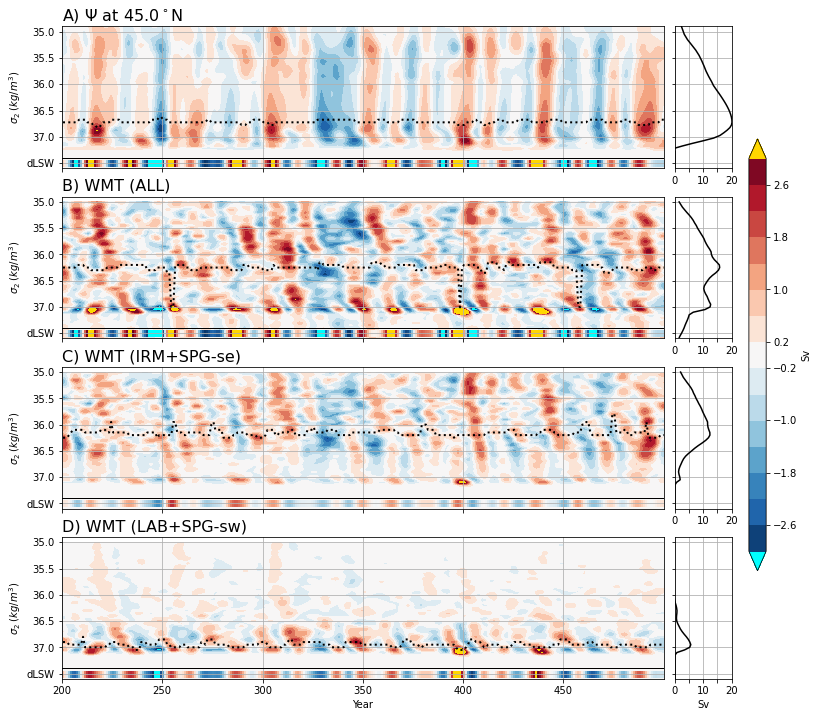

In [19]:
# Year 200-500 hovmuller plots
fig = plt.figure(figsize=(12, 12))
spec = fig.add_gridspec(ncols=10, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0, 0:9])
ax1a = fig.add_subplot(spec[0, 9])
ax2 = fig.add_subplot(spec[1, 0:9])
ax2a = fig.add_subplot(spec[1, 9])
ax4 = fig.add_subplot(spec[2, 0:9])
ax4a = fig.add_subplot(spec[2, 9])
ax6 = fig.add_subplot(spec[3, 0:9])
ax6a = fig.add_subplot(spec[3, 9])

ylat = 45.
xlim=[200,500]
ylim=[37.6,34.9]
ylim2=[28.1, 27.0]

#tann = np.linspace(6.5, 495.5, num=490)
tann = np.linspace(200.5, 500.5, num=301)
#levs = np.arange(0,21,1)*0.25-2.5
levs = np.arange(0,16,1)*0.4 - 3
levs2 = [-3,-2,-1,1,2,3]
sigslice = slice(36.95,38.0)
sigclrs = ['w','w','w','k','k','k']
#sigclrs = ['cyan','cyan','cyan','gold','gold','gold']
yticks = [37.5,37,36.5,36,35.5,35]
yticklabs = ('dLSW','37.0','36.5','36.0','35.5','35.0')
xticks1 = [200,250,300,350,400,450]
xtick1labs = ('200','250','300','350','400','450')
xticks2 = [0,5,10,15,20]
xtick2labs = ('0','','10','','20')

#colmap = copy.copy(plt.cm.bwr)
#colmap = copy.copy(plt.cm.seismic)
colmap = copy.copy(plt.cm.RdBu_r)
overclr = 'gold'
#overclr = 'white'
underclr = 'cyan'

simstr = 'HR'
work2 = ds2_hr_lpanom_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=ylat,method='nearest')
work2a = ds2_hr_lpann_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=ylat,method='nearest')
work3 = ds3_hr_lpanom_dt.WMT
work3a = ds3_hr_lpann_dt.WMT
work4 = ds3_hr_lpanom_dt.WMF
work5 = work4.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')

markery = work5.copy()
markery.values[:] = 37.5
#work5 = work4.isel(wmf_region=0).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1]))
#work5 = work5.where(work5>0)
#lswmax = work5.sigma_wmf[work5.argmax(axis=1)]

ax1.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title(r'A) $\Psi$ at {}$^\circ$N'.format(ylat), fontdict={'size':16}, loc='left')
cntr1 = ax1.contourf(tann, work2.moc_s,work2.T,cmap=colmap,levels=levs,extend='both')
cntr1.cmap.set_under(underclr)
cntr1.cmap.set_over(overclr)
cntr1.changed()
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=0).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr1b = ax1.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
sig2max1 = work2a.moc_s[work2a.argmax(axis=1)]
plt1 = ax1.plot(tann, sig2max1,color='k',linewidth=2,linestyle='dotted')
ax1.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax1.grid()
ax1.set_xticks(xticks1)
ax1.set_xticklabels([])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabs)

mn = work2a.mean('time')
ax1a.plot(mn,mn.moc_s, color='black', label=simstr)
ax1a.set_ylim(ylim)
ax1a.set_yticklabels([])
ax1a.set_xlim([0,20])
ax1a.set_xticks(xticks2)
ax1a.set_xticklabels(xtick2labs)
ax1a.grid()

ax2.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_title('B) WMT (ALL)', fontdict={'size':16}, loc='left')
cntr2 = ax2.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=0).T,cmap=colmap,levels=levs,extend='both')
cntr2.cmap.set_under(underclr)
cntr2.cmap.set_over(overclr)
cntr2.changed()
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=0).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr2b = ax2.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
clim = work3a.isel(wmf_region=0)
sig2max2 = clim.sigma_wmt[clim.argmax(axis=1)]
ax2.plot(tann, sig2max2,color='k',linewidth=2,linestyle='dotted')
ax2.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax2.grid()
ax2.set_xticks(xticks1)
ax2.set_xticklabels([])
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=0).mean('time')
ax2a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax2a.set_ylim(ylim)
ax2a.set_yticklabels([])
ax2a.set_xlim([0,20])
ax2a.set_xticks(xticks2)
ax2a.set_xticklabels(xtick2labs)
ax2a.grid()

ax4.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax4.set_ylim(ylim)
ax4.set_xlim(xlim)
ax4.set_title('C) WMT (IRM+SPG-se)', fontdict={'size':16}, loc='left')
cntr4 = ax4.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=10).T,cmap=colmap,levels=levs, extend='both')
cntr4.cmap.set_under(underclr)
cntr4.cmap.set_over(overclr)
cntr4.changed()
clim = work3a.isel(wmf_region=10)
sig2max4 = clim.sigma_wmt[clim.argmax(axis=1)]
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr4b = ax4.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
ax4.plot(tann, sig2max4,color='k',linewidth=2,linestyle='dotted')
ax4.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax4.grid()
ax4.set_xticks(xticks1)
ax4.set_xticklabels([])
ax4.set_yticks(yticks)
ax4.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=10).mean('time')
ax4a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax4a.set_ylim(ylim)
ax4a.set_yticklabels([])
ax4a.set_xlim([0,20])
ax4a.set_xticks(xticks2)
ax4a.set_xticklabels(xtick2labs)
ax4a.grid()

ax6.set_xlabel('Year')
ax6.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax6.set_ylim(ylim)
ax6.set_xlim(xlim)
ax6.set_title('D) WMT (LAB+SPG-sw)', fontdict={'size':16}, loc='left')
cntr6 = ax6.contourf(tann, work3.sigma_wmt,work3.isel(wmf_region=9).T,cmap=colmap,levels=levs, extend='both')
cntr6.cmap.set_under(underclr)
cntr6.cmap.set_over(overclr)
cntr6.changed()
clim = work3a.isel(wmf_region=9)
sig2max6 = clim.sigma_wmt[clim.argmax(axis=1)]
work5 = ds3_hr_lpanom_dt.WMF.isel(wmf_region=9).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
cntr6b = ax6.scatter(tann,markery,c=work5,marker='s',cmap=colmap,vmin=-3,vmax=3.)
ax6.plot(tann, sig2max6,color='k',linewidth=2,linestyle='dotted')
ax6.plot(xlim, [37.4,37.4],color='k',linewidth=1)
ax6.grid()
ax6.set_xticks(xticks1)
ax6.set_xticklabels(xtick1labs)
ax6.set_yticks(yticks)
ax6.set_yticklabels(yticklabs)

mn = work3a.isel(wmf_region=9).mean('time')
ax6a.set_xlabel('Sv')
ax6a.plot(mn,mn.sigma_wmt, color='black', label=simstr)
ax6a.set_ylim(ylim)
ax6a.set_yticklabels([])
ax6a.set_xlim([0,20])
ax6a.set_xticks(xticks2)
ax6a.set_xticklabels(xtick2labs)
ax6a.grid()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', 
             ticks=[-2.6,-1.8,-1.0,-0.2,0.2,1.0,1.8,2.6],extend='both')

plt.savefig('Fig_5.pdf')